# Network

Goal of this part: Train an Autoencoder on our scattering patterns.

Steps:
1. Define the architecture of the *encoder* and *decoder* that make up an *autoencoder*
2. Select *hyperparameters* (*learning rate*, *batch size*, ..) for the training
3. Load the data (with the data loader that we used before)
4. Train our model
5. Look at the results

Outlook for the next tutorial sections:
- Fitting: What happens during the training?
- Dimensionality reduction: Using the latent space for data exploration

In [106]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Basic Neural Network Setup in PyTorch

[`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) is the base class for neural network models in PyTorch. 
When defining your own model, the class you create for the model should be a subclass of this class. It should initialize its super class and overwrite the `forward` function. 

```python
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Definition of your model
        # For simple models such as the autoencoder you can use 
        # pre-defined layers and functions available in PyTorch 
        # and wrap them in nn.Sequential() that chains these togehter
        # Typical in an Autoencoder: 
        # - Fully connected layers: 
        #   nn.Linear(input_dim, output_dim)
        # - Activation functions: 
        #   nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.LeakyReLU().  
        self.model = nn.Sequential(nn.Linear(64*64, 32), nn.nn.ReLU())

    def forward(self, x):
        # Definition of the forward step
        return self.model(x)

```

# Autoencoder

An autoencoder consists of two parts: the *encoder* and the *decoder*. 

The encoder takes the input data and consists of layers with successively smaller and smaller number of output neurons, thus reducing the data in dimensionality. The output of the final layer of the encoder is referred to as *latent space* representation.

The decoder does to opposite. Encoder and decoder are trained together, such that input to the encoder matches the output of the decoder. 

In [107]:
class Encoder(nn.Module):
    def __init__(self, input_size=64 * 64, latent_dim=32):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(nn.Linear(input_size, latent_dim), nn.ReLU())

    def forward(self, x):
        # Feed x (the input image) into the encoder
        return self.encoder(x)

The configuration of the encoder (how many layers, dimensionality of the layers) determines how many *weights* or *parameters* need to be optimized during training. They can be inspected with the `.parameters()` function.

Changing the size of the latent space will adapt the total number of weights.

In [108]:
encoder = Encoder()
# encoder = Encoder(latent_dim = 40)
for param in encoder.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([32, 4096])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])


In [109]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=32, output_size=64 * 64):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.output_size = output_size

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.output_size), nn.ReLU()
        )

    def forward(self, x):
        # Feed x (the result from the encoder) into the decoder
        return self.decoder(x)

In [110]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size=64 * 64, latent_dim=32):
        super(AutoEncoder, self).__init__()

        self.input_size = input_size
        self.latent_dim = latent_dim

        self.encoder = Encoder(input_size=self.input_size, latent_dim=self.latent_dim)
        self.decoder = Decoder(latent_dim=self.latent_dim, output_size=self.input_size)

    def forward(self, x):
        # Feed x (the input image) through the entire autoencoder
        # i.e. calculate the reconstructed image
        latent_representation = self.encoder(x)
        return self.decoder(latent_representation)

# Hyperparameters

*Hyperparameters* are parameters that affect the model architecture, the split of the data into test, training and validation set, and the overall training procedure. 

Some examples for hyperparameters are the number of *epochs* (training steps), the *batch size* (how many data points inform a single parameter update), the *learning rate* (how large of a step to take in each update), and the type of *optimizer* (how to take the update step).

In [111]:
hyper_parameters = {
    "num_epochs": 100,
    "batch_size": 40,
    "learning_rate": 1e-3,
    "latent_dim": 64 * 8,
}

# Model initialization

With these ingredients, we can set up our model and the training procedure. 

We also need to define how the network will be optimized by specifying a *loss* and an *optimizer*.

In [112]:
# Initialize the model we just defined
autoencoder = AutoEncoder(input_size=64 * 64, latent_dim=hyper_parameters["latent_dim"])

# Loss function

The loss is a measure of how well the network is performing. 

For the scattering pattens, we can capture network performance well by measuring the mean squared error ([`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)) between input and output. This compares each input pixel with each output pixel. 




In [113]:
# Using mean square error as the loss function
loss_function = nn.MSELoss()

### Optimizer

The optimizer specifies how we use the information gained to improve our parameters.
Some commonly optimizers are *Adam* ([`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam)), *RMSProp* ([`torch.optim.RMSProp`](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html)) and *stochastic gradient descent* ([`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)). 

They differ in which additional hyperparamters can be specified, but all have in common that they use a *learning rate* to determine the size of the step to take.

In [114]:
# Using Adam as the optimizer
# We pass the parameters to optimize (the network weights)
# as well as any optimizer-specific hyperparamers
optimizer = torch.optim.Adam(
    autoencoder.parameters(), lr=hyper_parameters["learning_rate"]
)

# Data Loader

We load the data as before

In [115]:
import glob
from torchvision import datasets, transforms
from PIL import Image


class MyDataset(torch.utils.data.Dataset):
    """
    Args:
        folder  str, folder path
        format  str, formats supported by PIL
        label   int, default 0

    Return:
        tensor dataset  tuple, (image, label)
    """

    def __init__(self, folder, format=None, label=None, input_size=None):
        _file_path = folder + "/*." + format if format else folder + "/*"
        self.dataset = glob.glob(_file_path)  # filename matching
        self.label = label if label else 0
        self.input_size = input_size if input_size else 64

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        process = transforms.Compose(
            [
                transforms.Resize(self.input_size),
                transforms.CenterCrop(self.input_size),
                transforms.ToTensor(),
                transforms.Normalize(0.5, 0.5),
            ]
        )
        return process(Image.open(data)), self.label


dataset = MyDataset("data/data_64x64_400/")

In [116]:
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(
    train_dataset, batch_size=hyper_parameters["batch_size"], shuffle=True
)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=hyper_parameters["batch_size"], shuffle=False
)

# Training

In [117]:
num_epochs = hyper_parameters["num_epochs"]
epoch_loss = []
epoch_validation_loss = []

for epoch in range(num_epochs):
    # Set to training mode
    autoencoder.train()
    for batch in train_dataloader:
        # Omit the labels (we do not have any)
        input_patterns, _ = batch
        # Flatten the input pattern
        input_patterns = input_patterns.reshape(-1, 64 * 64)
        # --- Forward step ---
        reconstructions = autoencoder(input_patterns)
        loss = loss_function(reconstructions, input_patterns)
        # --- Backward step ---
        # Set the gradients to zero (otherwise they accumulate)
        optimizer.zero_grad()
        # Calulate the gradients for the loss
        loss.backward()
        # Take the optimization step
        optimizer.step()

    # loss.item() returns the loss of the last batch, divided by the batch size
    epoch_loss.append(loss.item())

    # Set to evaluation mode (no tracking of gradients, saves some memory)
    autoencoder.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_batch in validation_dataloader:
            input_patterns, _ = validation_batch
            input_patterns = input_patterns.reshape(-1, 64 * 64)
            reconstructions = autoencoder(input_patterns)
            loss = loss_function(reconstructions, input_patterns)
            validation_loss += loss.item()
    avg_validation_loss = validation_loss / len(validation_dataloader)
    epoch_validation_loss.append(avg_validation_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}],",
            f"Loss: {loss.item():.6f}, ",
            f"Validation Loss: {avg_validation_loss:.6f}",
        )

Epoch [10/100], Loss: 0.137144,  Validation Loss: 0.136244
Epoch [20/100], Loss: 0.132727,  Validation Loss: 0.131572
Epoch [30/100], Loss: 0.131043,  Validation Loss: 0.129837
Epoch [40/100], Loss: 0.130449,  Validation Loss: 0.129284
Epoch [50/100], Loss: 0.131124,  Validation Loss: 0.130160
Epoch [60/100], Loss: 0.129983,  Validation Loss: 0.128754
Epoch [70/100], Loss: 0.130086,  Validation Loss: 0.128864
Epoch [80/100], Loss: 0.129698,  Validation Loss: 0.128382
Epoch [90/100], Loss: 0.129707,  Validation Loss: 0.128498
Epoch [100/100], Loss: 0.129891,  Validation Loss: 0.128556


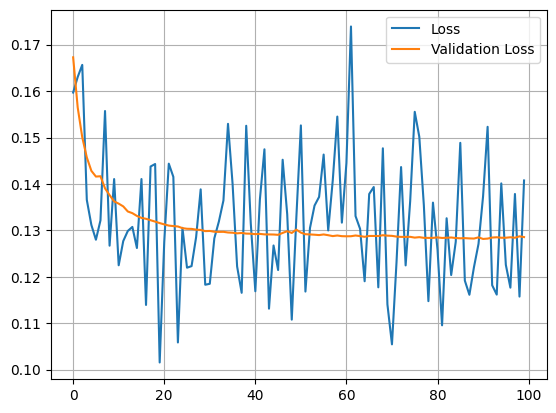

In [118]:
plt.plot(epoch_loss)
plt.plot(epoch_validation_loss)
plt.legend(["Loss", "Validation Loss"])
plt.grid()

In [119]:
import numpy as np
import random

validation_input_patterns = []
validation_reconstructions = []
with torch.no_grad():
    for batch in validation_dataloader:
        input_patterns, _ = batch
        validation_input_patterns.append(input_patterns.detach().cpu().numpy())
        input_patterns = input_patterns.reshape(-1, 64 * 64)
        validation_reconstructions.append(
            autoencoder(input_patterns).detach().cpu().numpy()
        )
validation_set = np.vstack(validation_input_patterns)
reconstructed_set = np.vstack(validation_reconstructions)

Epoch 0:   0%|          | 0/8 [01:12<?, ?it/s]


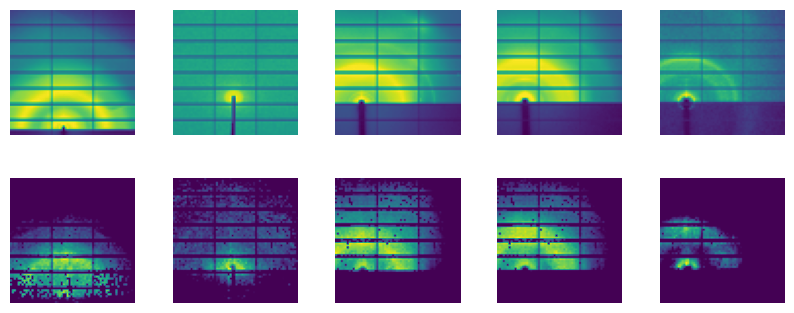

In [120]:
# Randomly selectes 5 images from the validation set
indxs = random.sample(range(len(reconstructed_set)), 5)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    original_img = validation_set[indxs[i]]
    reconstructed_img = reconstructed_set[indxs[i]].reshape(64, 64)
    axs[0, i].imshow(np.squeeze(original_img))
    axs[0, i].axis("off")
    axs[1, i].imshow(np.squeeze(reconstructed_img))
    axs[1, i].axis("off")
plt.subplots_adjust(wspace=0.3, hspace=0.2)

# Bonus - Using PyTorch Lightning

In [121]:
import lightning.pytorch as pl


# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, input_size=64 * 64, latent_dim=32):
        # This is the same as the previous AutoEncoder __init__ function
        super().__init__()

        self.input_size = input_size
        self.latent_dim = latent_dim

        self.encoder = Encoder(input_size=self.input_size, latent_dim=self.latent_dim)
        self.decoder = Decoder(latent_dim=self.latent_dim, output_size=self.input_size)

        self.loss_function = nn.MSELoss()

    def training_step(self, batch, batch_idx):
        # Instead of forward we define the full training step
        input_patterns, _ = batch
        input_patterns = input_patterns.reshape(-1, self.input_size)
        latent_representations = self.encoder(input_patterns)
        reconstructions = self.decoder(latent_representations)
        loss = loss_function(reconstructions, input_patterns)
        self.log("Training loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=hyper_parameters["learning_rate"]
        )
        return optimizer


# Init the autoencoder
pl_autoencoder = LitAutoEncoder(
    input_size=64 * 64, latent_dim=hyper_parameters["latent_dim"]
)

In [122]:
# train the model
trainer = pl.Trainer(
    max_epochs=hyper_parameters["num_epochs"],
    log_every_n_steps=len(train_dataset) / hyper_parameters["batch_size"],
)
trainer.fit(model=pl_autoencoder, train_dataloaders=train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type    | Params
------------------------------------------
0 | encoder       | Encoder | 2.1 M 
1 | decoder       | Decoder | 2.1 M 
2 | loss_function | MSELoss | 0     
------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.796    Total estimated model params size (MB)


Epoch 99: 100%|██████████| 8/8 [00:00<00:00, 74.40it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 8/8 [00:00<00:00, 54.43it/s, v_num=8]
